# Search Tree

In [110]:
#importing packages we need
import pandas as pd
import random
import jieba
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from collections import defaultdict
import re
import math
from scipy.spatial.distance import cosine
import wordcloud
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import and_
import networkx as nx
from string import ascii_uppercase
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [19]:
content = pd.read_csv('sqlResult_1558435.csv', encoding = 'gb18030')
content = content.fillna('')

In [20]:
news_content = content['content'].tolist()

In [21]:
def cut(string):
    return ' '.join(jieba.cut(string))

In [22]:
#Test
cut('这是一个小小的测试')

'这是 一个 小小的 测试'

In [23]:
def token(string):
    return re.findall(r'[\d|\w]+',string)

In [24]:
token('你好啊我是一个小可爱/lsdjnc')

['你好啊我是一个小可爱', 'lsdjnc']

In [25]:
news_content = [token(n) for n in news_content]

In [26]:
news_content[1]

['骁龙835作为唯一通过Windows',
 '10桌面平台认证的ARM处理器',
 '高通强调',
 '不会因为只考虑性能而去屏蔽掉小核心',
 '相反',
 '他们正联手微软',
 '找到一种适合桌面平台的',
 '兼顾性能和功耗的完美方案',
 '报道称',
 '微软已经拿到了一些新的源码',
 '以便Windows',
 '10更好地理解big',
 'little架构',
 '资料显示',
 '骁龙835作为一款集成了CPU',
 'GPU',
 '基带',
 '蓝牙',
 'Wi',
 'Fi的SoC',
 '比传统的Wintel方案可以节省至少30',
 '的PCB空间',
 '按计划',
 '今年Q4',
 '华硕',
 '惠普',
 '联想将首发骁龙835',
 'Win10电脑',
 '预计均是二合一形态的产品',
 '当然',
 '高通骁龙只是个开始',
 '未来也许还能见到三星Exynos',
 '联发科',
 '华为麒麟',
 '小米澎湃等进入Windows',
 '10桌面平台']

In [27]:
news_content = [' '.join(n) for n in news_content]

In [28]:
news_content[1]

'骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器 高通强调 不会因为只考虑性能而去屏蔽掉小核心 相反 他们正联手微软 找到一种适合桌面平台的 兼顾性能和功耗的完美方案 报道称 微软已经拿到了一些新的源码 以便Windows 10更好地理解big little架构 资料显示 骁龙835作为一款集成了CPU GPU 基带 蓝牙 Wi Fi的SoC 比传统的Wintel方案可以节省至少30 的PCB空间 按计划 今年Q4 华硕 惠普 联想将首发骁龙835 Win10电脑 预计均是二合一形态的产品 当然 高通骁龙只是个开始 未来也许还能见到三星Exynos 联发科 华为麒麟 小米澎湃等进入Windows 10桌面平台'

In [29]:
news_content= [cut(n) for n in news_content[:10000]]

In [30]:
with open('test_context.txt', 'w') as f:
    for n in news_content:
        f.write(n + '\n')

In [31]:
lines = LineSentence('test_context.txt')

In [32]:
news_word2vec = Word2Vec(lines, size = 35, min_count=1)

In [33]:
news_word2vec.most_similar('西班牙',topn = 10)

/Users/air/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('意大利', 0.8675029277801514),
 ('迄今', 0.8669703602790833),
 ('澳大利亚', 0.8594093322753906),
 ('传教士', 0.8503321409225464),
 ('巴基斯坦', 0.8429580926895142),
 ('缅甸', 0.8388609886169434),
 ('埃及', 0.8339178562164307),
 ('福布斯', 0.8303227424621582),
 ('令人费解', 0.8293337821960449),
 ('法国', 0.8258199691772461)]

# Building Search Engine

In [35]:
#Optimizing the searching engine
def get_related_words(init_words, model, max_size, top_n):
    """
    @ init_words: initial words we already know
    @ model: the word2vec model
    @ max_size: the maximum number of words need to see
    @ top_n: the number of top similar words
    """
    
    # Init unseen words list
    unseen_list = init_words
    
    # Init seen words dict
    seen = defaultdict(int)
    
    # Init sub nodes dict
    sub_nodes_dic = defaultdict(list)
    
    # Scan unseen words list if length of seen words dict less than max_size
    while unseen_list and len(seen) < max_size:
        
        # Get first word in unseen words list
        node = unseen_list.pop(0)
        
        # Get sub nodes directly if in dict
        if node in sub_nodes_dic:
            sub_nodes = sub_nodes_dic[node]
        
        else:
            # Get top_n similar words for first word by word2vec model
            sub_nodes = [w for w, s in model.wv.most_similar(node, topn=top_n)]
            
            # Save result to sub nodes dict
            sub_nodes_dic[node] = sub_nodes
        
        # Add similar words result to unseen words list
        unseen_list += sub_nodes
        
        # Save current seen word and increase 1 weight
        seen[node] += 1 # could be weighted by others
        
        # optimal: 1. score function could be revised
    
    # Sort seen words dict by words weight
    seen_rank = sorted(seen.items(), key=lambda x: x[1], reverse=True)
    
    # Return sorted list
    return seen_rank

In [34]:
len(news_word2vec.wv.vocab)

139205

In [38]:
get_related_words(['说'], news_word2vec, 10,10)

[('说', 1),
 ('表示', 1),
 ('坦言', 1),
 ('告诉', 1),
 ('看来', 1),
 ('透露', 1),
 ('认为', 1),
 ('彭先生', 1),
 ('卡纳尔', 1),
 ('说道', 1)]

# TFIDF KEY WORDS

In [39]:
news_content[0]

'此外   自 本周   6 月 12 日   起   除 小米 手机 6 等 15 款 机型 外   其余 机型 已 暂停 更新 发布   含 开发 版   体验版 内测   稳定版 暂不受 影响   以 确保 工程师 可以 集中 全部 精力 进行 系统优化 工作   有人 猜测 这 也 是 将 精力 主要 用到 MIUI   9 的 研发 之中   MIUI   8 去年 5 月 发布   距今已有 一年 有余   也 是 时候 更新换代 了   当然   关于 MIUI   9 的 确切 信息   我们 还是 等待 官方消息'

In [40]:
def document_frequency(word):
    return sum(1 for n in news_content if word in n)

In [41]:
document_frequency('的')

7665

In [43]:
def idf(word):
    return math.log10(len(news_content) / document_frequency(word))

In [44]:
idf('的') < idf('小米')

True

In [45]:
def tf(word, document):
    words = document.split()
    return sum(1 for w in words if w== word)

In [46]:
content['content'][11]

'?\r\n\u3000\u3000巨丰早评：市场将再次探底\r\n\u3000\u3000【巨丰观点】\r\n\u3000\u3000周四大盘冲高回落，2500余只个股下跌。上证50、沪深300指数顽强收红。早盘大盘低开高走，展开反弹，沪指冲破120日均线压力位；午后大盘跳水，个股普跌。盘面上，保险、电力、银行、民航机场、券商、房地产、人工智能、迪士尼、网络安全等板块涨幅居前。雄安新区、福州新区、医疗器械、丝绸之路等跌幅居前。\r\n\u3000\u3000金融股全线大涨：保险板块涨3%：新华保险、中国太保、中国人寿涨4%，中国平安涨2%；西水股份、天茂集团盘中大涨7%以上。银行板块涨2%：招商银行大涨8%，贵阳银行、兴业银行、浦发银行、兴业银行等涨幅居前。金融股是A股纳入MSCI指数的受益者，后市可以逢低关注。\r\n\u3000\u3000盘中万达电影、复星医药等白马股闪崩，导致午后市场出现大幅跳水。盘后消息，银监会于6月中旬要求各家银行排查包括万达、海航集团、复星、浙江罗森内里在内数家企业的授信及风险分析，排查对象多是近年来海外投资比较凶猛、在银行业敞口较大的民营企业集团。\r\n\u3000\u3000巨丰投顾认为自5月以来，大盘已经走出了3重底的走势，并开启中级反弹行情。沪指在上证50及白马股推动下率先反弹，但遭遇60日、120日均线强压力而出现调整。MSCI纳入A股后，沪深300指数创17个月新高，但2500余股下跌，市场分化明显。随着6月末市场流动性紧张的可能出现，市场将再次出现探底。建议投资者重点关注半年报大幅预增的错杀股和具备估值优势的大蓝筹。\r\n\u3000\u3000天信投资：尾盘跳水原因揭秘 伏击的品种曝光\r\n\u3000\u3000周四市场点评：\r\n\u3000\u3000沪深两市早盘纷纷低开，但是开盘之后权重板块崛起，其中保险和银行表现尤其明显，低矮动股指快速拉升，并顺势突破了60日均线和半年线的束缚；在主板拉升的过程中，市场的分化格局也较明显，题材板块和创业板表现相对较弱。不过虽然市场在早盘的上攻，但是成交量萎缩明教明显，所以这种上涨比较虚。果不其然，午后个股再度纷纷杀跌，同时股指也是顺势回落，沪市的半年线得而复失，形成长长的上影线；而创业板股指在回落的过程中失守5日均线的支撑。整体上周四市场全天保持宽幅震荡走势，尤其是沪

In [47]:
tf('银行',news_content[11])

6

In [48]:
tf('创业板',news_content[11])

6

In [49]:
tf('的',news_content[11])

42

In [50]:
idf('创业板')

1.7695510786217261

In [51]:
idf('银行')

1.0846001647877301

In [52]:
def get_keywords_of_a_ducment(document):
    words = set(document.split())
    
    tfidf = [
        (w, tf(w, document) * idf(w)) for w in words
    ]
    
    tfidf = sorted(tfidf, key=lambda x: x[1], reverse=True)
    
    return tfidf

In [53]:
news_content[0]

'此外   自 本周   6 月 12 日   起   除 小米 手机 6 等 15 款 机型 外   其余 机型 已 暂停 更新 发布   含 开发 版   体验版 内测   稳定版 暂不受 影响   以 确保 工程师 可以 集中 全部 精力 进行 系统优化 工作   有人 猜测 这 也 是 将 精力 主要 用到 MIUI   9 的 研发 之中   MIUI   8 去年 5 月 发布   距今已有 一年 有余   也 是 时候 更新换代 了   当然   关于 MIUI   9 的 确切 信息   我们 还是 等待 官方消息'

In [63]:
machine_new_keywords = get_keywords_of_a_ducment(news_content[101])

In [55]:
%prun get_keywords_of_a_ducment(news_content[0])

# Word Cloud

In [60]:
wc = wordcloud.WordCloud('SourceHanSerifSC-Regular.otf')

In [61]:
news_content[4]

'原 标题   44 岁 女子 跑 深圳 约会 网友 被 拒   暴雨 中 裸身 奔走   深圳 交警 微博称   昨日 清晨 交警 发现 有 一 女子 赤裸 上身   行走 在 南坪 快速 上   期间 还 起 了 轻生 年头   一辅警 发现 后 赶紧 为 其 披上 黄衣   并 一路 劝说 她   那么 事发 时   到底 都 发生 了 些 什么 呢   南 都 记者 带 您 一起 还原 现场   南 都 记者 在 龙岗 大队 坂田 中队 见到 了 辅警 刘青   发现 女生 的 辅警   一位 外表 高大 帅气   说话 略带 些 腼腆 的 90 后 青年   刘青 介绍   6 月 16 日 早上 7 时 36 分   他 正在 环城 南路 附近 值勤   接到 中队 关于 一位 女子 裸身 进入 机动车 可能 有 危险 的 警情   随后 骑着 小 铁骑 开始 沿路 寻找   大概 花 了 十多分钟 在 南坪 大道 坂田 出口 往 龙岗 方向 的 逆行 辅道 上 发现 该 女子   女子 身上 一丝不挂 地逆 车流 而行   时 走时 停   时 坐 时 躺   险象环生   刘青停 好 小 铁骑   和 另外 一名 巡防 员 追 了 上去   发现 女子 的 情绪 很 低落   话 不 多   刘青 尝试 和 女子 交流   劝说 女子 离开   可 女子 并 不 愿意 接受   继续 缓慢 地往 南坪 快速路 的 主干道 上 走 去   此时 路边 上 已经 聚集 了 很 市民 围观   为了 不 刺激 女子 的 情绪   刘青 和 巡防 员 一边 盯 着 女子 一边 驱赶 着 围观 的 群众   现场 还原   从 警方 提供 的 一份 视频 了解 到   16 日 早上 7 时 25 分   女子 出现 在 坂雪岗 大道 与 环城 南路 的 监控 视频 中   此时 女子 还 穿着 白色 的 内裤   正 沿着 坂雪岗 大道 往 南坪 快速 的 方向 缓慢 地 走 着   当时 正值 上班 高峰期   十字路口 的 车流 已经 排起 了 长队   当 女子 出现 时   路上 的 市民 纷纷 驻足 观望   不少 车辆 也 放慢 了 速度   但 女子 并 不 为 市民 观望 停下 脚步   依然 缓慢 走 着   当 女子 行进 到 十字路口 

In [62]:
help(wc.generate_from_frequencies)

Help on method generate_from_frequencies in module wordcloud.wordcloud:

generate_from_frequencies(frequencies, max_font_size=None) method of wordcloud.wordcloud.WordCloud instance
    Create a word_cloud from words and frequencies.
    
    Parameters
    ----------
    frequencies : dict from string to float
        A contains words and associated frequency.
    
    max_font_size : int
        Use this font-size instead of self.max_font_size
    
    Returns
    -------
    self



In [65]:
machine_new_keywords_dict = {w :score for w, score in machine_new_keywords}

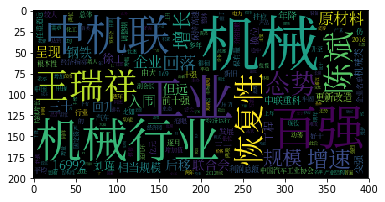

In [66]:
plt.imshow(wc.generate_from_frequencies(machine_new_keywords_dict))

In [67]:
shenzhen_news = get_keywords_of_a_ducment(news_content[4])

In [72]:
shenzhen_dict = {w: s for w, s in shenzhen_news}

In [70]:
shenzhen_news[:10]

[('女子', 59.62688825430277),
 ('刘青', 52.84318117920506),
 ('南坪', 22.193820026016112),
 ('交警', 12.96690545557647),
 ('坂田', 11.096910013008056),
 ('巡防', 10.193820026016112),
 ('黄衣', 10.193820026016112),
 ('轻生', 8.65816994307949),
 ('护栏', 8.387640052032227),
 ('约会', 8.234182484690082)]

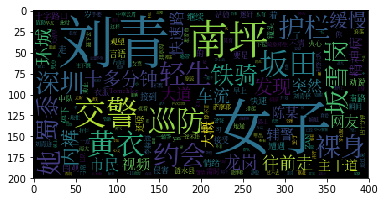

In [73]:
plt.imshow(wc.generate_from_frequencies(shenzhen_dict))

# TFIDF VECTORIZED

In [75]:
vectorized = TfidfVectorizer(max_features=10000)

In [77]:
X = vectorized.fit_transform(news_content)

In [78]:
X.shape

(10000, 10000)

In [83]:
document_id_1, document_id_2 = random.randint(0, 1000), random.randint(0, 1000)

In [86]:
vector_of_news_1 = X[document_id_1].toarray()[0]

In [87]:
vector_of_news_1

array([0., 0., 0., ..., 0., 0., 0.])

In [88]:
vector_of_news_2 = X[document_id_2].toarray()[0]

In [89]:
vector_of_news_2

array([0., 0., 0., ..., 0., 0., 0.])

In [91]:
def distance(v1,v2):
    return cosine(v1,v2)

In [92]:
distance([1,1],[2,1])

0.05131670194948623

In [93]:
random_choice = random.randint(0,1000)

In [94]:
distance(X[random_choice].toarray()[0], vector_of_news_1)

0.9850370488732023

In [95]:
distance(X[random_choice].toarray()[0], vector_of_news_2)

0.9596269047156818

# Building Search Engine

In [99]:
def naive_search(keywords):
    news_ids = [i for i, n in enumerate(news_content) if all(w in n for w in keywords)]
    return news_ids

In [100]:
naive_search('美军 司令 航母'.split())

[2844]

In [101]:
transposed_x = X.transpose().toarray()

In [102]:
word_2_id = vectorized.vocabulary_

In [104]:
id_2_word = {d:w for w, d in word_2_id.items()}

In [106]:
id_2_word[2844]

'受理'

In [108]:
set(np.where(transposed_x[6195])[0])

{4,
 77,
 122,
 139,
 197,
 200,
 220,
 225,
 230,
 232,
 248,
 261,
 299,
 310,
 312,
 326,
 352,
 354,
 428,
 463,
 504,
 523,
 533,
 564,
 609,
 616,
 645,
 694,
 700,
 708,
 713,
 716,
 725,
 751,
 755,
 763,
 798,
 821,
 834,
 881,
 886,
 890,
 930,
 950,
 969,
 996,
 1016,
 1020,
 1040,
 1073,
 1095,
 1129,
 1149,
 1164,
 1200,
 1203,
 1243,
 1279,
 1298,
 1481,
 1499,
 1590,
 1626,
 1648,
 1671,
 1696,
 1709,
 1723,
 1779,
 1783,
 1785,
 1793,
 1797,
 1813,
 1823,
 1904,
 1925,
 2071,
 2098,
 2200,
 2234,
 2299,
 2301,
 2307,
 2312,
 2343,
 2377,
 2381,
 2411,
 2436,
 2485,
 2493,
 2556,
 2771,
 2812,
 2824,
 2853,
 2861,
 2915,
 2938,
 2971,
 2996,
 3037,
 3100,
 3102,
 3136,
 3140,
 3157,
 3175,
 3186,
 3206,
 3224,
 3248,
 3278,
 3337,
 3349,
 3463,
 3482,
 3487,
 3527,
 3537,
 3538,
 3586,
 3597,
 3608,
 3617,
 3689,
 3704,
 3817,
 3857,
 3877,
 3991,
 4047,
 4069,
 4077,
 4080,
 4109,
 4135,
 4144,
 4173,
 4217,
 4288,
 4313,
 4363,
 4434,
 4504,
 4534,
 4583,
 4612,
 4731,

In [112]:
usa_force = set(np.where(transposed_x[7922])[0])

In [111]:
commander = set(np.where(transposed_x[2769])[0])

In [113]:
usa_force & commander

{1013, 1699, 1718, 1810, 3125, 3166, 3474, 5199}

In [114]:
d1, d2, d3 = {1, 2, 3}, {4, 5, 6, 3, 2}, {1, 3, 4}

In [115]:
reduce(and_, [d1, d2, d3])

{3}

In [116]:
def search_engine(query):

    words = query.split()
    
    query_vec = vectorized.transform([' '.join(words)]).toarray()[0]

    candidates_ids = [word_2_id[w] for w in words]
    
    documents_ids = [
         set(np.where(transposed_x[_id])[0]) for _id in candidates_ids
    ]
    
    merged_documents = reduce(and_, documents_ids)
    # we could know the documents which contain these words
    sorted_docuemtns_id = sorted(merged_documents, key=lambda i: distance(query_vec, X[i].toarray()))

    return sorted_docuemtns_id

In [117]:
text = """美国有线电视新闻网援引美国军方官员的话说"""


In [120]:
pattern = r'(官员|新闻)'

In [121]:
re.compile(pattern).sub(repl="**\g<1>**", string=text)

'美国有线电视**新闻**网援引美国军方**官员**的话说'

In [122]:
def get_query_pat(query):
    return re.compile('({})'.format('|'.join(query.split())))

In [123]:
get_query_pat('美军 司令 航母')


re.compile(r'(美军|司令|航母)', re.UNICODE)

In [124]:
def highlight_keywords(pat, document):
    return pat.sub(repl="**\g<1>**", string=document)

In [125]:
highlight_keywords(get_query_pat('美军 司令 航母'), content['content'][22987])

'\u3000\u3000新华社北京４月１０日电新闻分析：“卡尔·文森”号**航母**缘何成西太平洋军情新主角\\n\u3000\u3000新华社记者刘莉莉\\n\u3000\u3000美国海军第三舰队下属的“卡尔·文森”号**航母**打击群即将抵达西太平洋朝鲜半岛附近水域。分析人士认为，美方此次急调**航母**打击群北上，向朝鲜施压意图明显，很可能会加剧朝鲜半岛紧张局势。\\n\u3000\u3000（小标题）侧重对地攻击\\n\u3000\u3000据第三舰队网站主页发布的消息，**美军**太平洋**司令**部**司令**哈里·哈里斯指示“卡尔·文森”号**航母**打击群从新加坡向北航行。这一打击群还包括海军第二航空队、两艘“阿利·伯克”级导弹驱逐舰和一艘“泰孔德罗加”级导弹巡洋舰。\\n\u3000\u3000“卡尔·文森”号是“尼米兹”级核动力**航母**，母港位于美国加利福尼亚州的圣迭戈，今年１月初，“卡尔·文森”号曾前往西太平洋地区执行任务，并参与美日韩三国军事演习。“尼米兹”级**航母**是核动力多用途**航母**，也是美国海军远洋作战群的核心力量。\\n\u3000\u3000“卡尔·文森”**航母**打击群中，“阿利·伯克”级导弹驱逐舰和“泰孔德罗加”级导弹巡洋舰也不可小视。“阿利·伯克”级导弹驱逐舰是世界上最先配备四面相控阵雷达的驱逐舰，舰队防空是其主要作战任务。“泰孔德罗加”级导弹巡洋舰的武器配备也比较全面，涵盖了反潜、反舰、防空和对地４个种类。\\n\u3000\u3000据军事专业人士介绍，**航母**打击群与**航母**战斗群其实是两个概念，战斗群侧重于夺取制海权，例如海战；而**航母**打击群更侧重于对地攻击作战。一般而言，打击群的舰艇数量要远少于战斗群。\\n\u3000\u3000（小标题）配角跻身主角\\n\u3000\u3000第三舰队是美国海军太平洋舰队两大舰队之一，拥有４个**航母**打击群，分别是以“卡尔·文森”号为核心的第一**航母**打击群、以“约翰·斯坦尼斯”号为核心的第三**航母**打击群、以“西奥多·罗斯福”号为核心的第九**航母**打击群和以“尼米兹”号为核心的第十一**航母**打击群。\u3000\\n\u3000\u3000资深军事评论员石宏说，在美国海军力量中，第三舰队原本地位一般，因为其所管辖的国际日期

In [127]:
def search_engine_with_pretty_print(query):
    candidates_ids = search_engine(query)
    for i, _id in enumerate(candidates_ids):
        title = '## Search Result {}'.format(i)
        c = content['content'][_id]
        c = highlight_keywords(get_query_pat(query), c)    
        
        display(Markdown(title + '\n' + c))

In [128]:
search_engine_with_pretty_print('春节 假期')

## Search Result 0
最近，不少人在朋友圈等个人社交媒体上吐槽打车难。人们发现，不仅在早晚高峰，甚至是传统的非高峰时段，都出现了路上扬招成功率越来越低，打车软件不加价或是加价少难以吸引司机接单的情况。而类似的情况，在上海、北京、武汉等地都或多或少地存在。
对此，一些城市迅游车的驾驶员们表示，历年**春节**前，都会遇到活多车少的情况。对司机而言，能加价赚到钱，何乐而不为呢？
21日晚8点，滴滴高级产品总监罗文在知乎上发文回应称，根据后台数据显示：今年司机回家早，运力下降。在其晒出有关“滴滴在线司机数据”和“北京订单需求”的两张手绘图表中，虽然隐去了具体数值，但可以明显看出，前一张图表近期呈现了直线下降趋势，标注数据显示下降超过25%。而出行订单数量则同期上涨了3成。
不过，在线司机变少的情况，仅仅是因为临近**假期**，专车司机纷纷提早回家过年造成的吗？
相关数据显示，自去年国庆之后，地方版网约车新政陆续出台后，市场上的网约车供给量就呈现出大幅减少的趋势。以上海为例，网约车新政之后，上海合规的网约车数量只有1万辆左右，市场供给大幅减少，打车难开始悄然回潮。
与此同时，网约车市场过度集中，部分平台一家独大。也让消费者瞬间，难以从补贴优惠的温情脉脉中回过神来，瞬间跌入了加价才能叫到车的冰冷现实中。
一位Uber中国早期员工指出，滴滴打车软件，自动设置了加价选项，即便第一次加价没被接单，还可以再次加价叫车。司机知道用户可以多次选择加价，就有意不接那些不加价的单子。他知道你叫不到车就会提高小费，就故意等着。于是，这个潜规则的结果，就是乘客反复加价才能叫到车，既浪费了时间，也付了更多的钱。
对于近日有消费者称打车难、打车贵的问题，23日下午，滴滴出行官方微博发布《致广大用户的一封信》表示，将从即日起，在全国范围内阶段性取消出租车“建议调度费”功能，以减少因为春运期间本身供不应求和价格因素带来的体验问题。
滴滴方面表示，此举将有可能给部分乘客带来呼叫等待时间的增加，以及打车成功率降低的影响。不过，为了鼓励在**春节**期间坚持出车的司机师傅，仍会保留用户主动给予调度费的功能，**春节**过后会根据用户的反馈再做决策。并强调，所有调度费滴滴分文不取。


## Search Result 1
即将进入7月，对于城市学生而言，美好的暑假又如期而至了，而对于另一群人——留守儿童而言，迎接他们的却是一个“冷清”的**假期**。离开了学校，没有了老师和同学的陪伴，也没有父母的守护，他们的**假期**是孤单而乏味的。
记者从清远相关部门获悉，清远农村留守儿童约2.39万名，数量在全省排名第四。留守儿童长期缺乏亲情关爱和有效保护，处境堪忧。为做好农村留守儿童关爱保护工作，促进农村留守儿童健康成长。近年来，清远不断完善制度方案为留守儿童撑起“保护伞”。
就在今年4月份，清远市政府常务会议审议了《清远市关于加强农村留守儿童关爱保护工作的实施方案》（稿）），提出建立考核机制，强化激励问责。对成效明显的，按照国家有关规定予以激励。对工作不力、措施不实、造成不良影响的，按规定追究相关人员的党纪政纪责任；造成严重后果的将对有关领导进行问责。
清远市心理学会会长张万英认为，不能让“留守儿童”成为“缺爱儿童”。不能经常和孩子在一起生活的父母，要争取多与孩子保持常态联系；不要让“留守儿童”成为“无助儿童”，政府要完善社区中留守儿童服务的功能，关注学生成长中遇到的生理、心理问题。
●采写/整理：魏金锋
“半年难见爹和娘”的无奈
每年七八月间，都是清远最热的时段。而往日喧闹的校园，一到这时便进入**假期**，一片沉寂。
“留守儿童真凄凉，半年难见爹和娘，放学回家忙家务，夜里梦中唤爹娘。”是农村留守儿童的真实写照。在粤北山区的清远市农村，“半年难见爹和娘”的儿童实在是太普遍了。为了给家人更好的生活环境，许多青壮年选择了背井离乡。他们像候鸟一样，每年**春节**刚过，便飞向沿海各个城市打工，直到下一个**春节**的到来，半年甚至几年不回家，也是常有的事。
对于很多父母在外务工的农村留守儿童而言，无论是留在家里，还是到父母身边团聚，怎样度过长达两个月的暑假，都是个难题。
一位经常在清远参加各种公益活动的志愿者刘小姐说，很多次当他们乘坐的车子进入到村头时，就像突然注入了活力一般，孩子们三三两两飞奔过来，小村瞬间变得生动起来。“孩子们好奇地围着大巴转，因为他们盼望父母会从车上走下来，可惜不是。”
目前，清远农村留守儿童数量在全省排名第四。留守儿童因为家庭环境的特殊性，在性格方面容易出现孤僻、偏激、冲动、攻击性比较强等缺陷；而亲情的缺乏和监管的缺失，让他们更容易受到外界因素的伤害。
笔者走访了解到，喜的是，由于父母不在身边，不少留守儿童在艰难的环境中早早学会了生存的技能，变得顽强独立；忧的是，个别留守儿童因为缺乏大人监管，安全隐患重重。
留守儿童也牵动着政府的心。近年来，清远各地通过政府购买服务等形式，探索和创新解决留守儿童问题的方式和途径，取得一定成效，但依旧任重道远。还需不断健全关爱留守儿童的法律和政策体系，强化父母法定监护责任等途径，缓解留守儿童问题。
亲情缺失监管缺乏的隐患
由于外出打工的父母长年累月难得有机会回一趟家，留守儿童缺乏父母的监护和保护，往往容易遭受伤害，比如溺水、烧伤、车祸甚至是性侵等等。
“其实我们也知道父母长期不在家对孩子的身心健康和学习会带来负面影响，但这是痛苦无奈的选择。”家住清远阳山的何先生夫妇感慨良多。他家有一双儿女，由于家里田地少，经济窘困，在小女儿断奶后，就把孩子留给年迈的父母抚养，夫妇俩到了佛山打工，一干就是9年多，每半年夫妻俩才轮流回家一两天。
9年过去了，夫妻俩好不容易挣了一些钱，去年回家盖起了新楼，并添置了一批家用电器。可谁知由于他俩长年不在家，两个孩子对父母的感情似乎都很生疏，大儿子经常逃学，小小年纪学会了抽烟饮酒，让这何先生夫妇非常伤心。
业内人士指出，留守儿童之所以容易出问题，主要还是思想道德教育得不到足够的重视。由于学校师资力量及父母不在身边教育的原因，留守儿童思想道德教育被严重忽视。
隔代监护人大多忙于务农，无暇教育儿童。而且，隔代监护人由于自身素质限制，教育水平不高、手段不当，不少留守儿童隔代监护人采取暴力手段“教育”儿童，错误的教育方式导致错误的教育成果。
此外，由于农村师资力量水平的限制，留守儿童在音乐、美术、舞蹈等艺术类学习上机会非常少甚至是基本空白。乡村小学对体育课、心理健康教育课的师资投入极少，留守儿童长期得不到心理生理健康教育上的辅导，导致容易出现沉迷网络、电视及抽烟喝酒等不良习惯。
让留守儿童的暑假不再孤单
张万英认为，留守儿童因为家庭环境的特殊性，在性格方面容易出现孤僻、偏激、冲动、攻击性比较强等缺陷；人格上容易出现精神问题，如抑郁症、焦虑、恐惧、人际交往障碍等；在学习方面容易出现学习落后、缺乏动力等；跟家庭关系也会相对紧张，容易跟家里人产生冲突，难以和谐相处。
农村留守儿童问题需要家庭、学校和社会的共同努力。一是加快新农村建设和小城镇建设，吸引外出农民工返乡就业创业，使留守儿童能够与父母团聚；二是学校要加强对留守儿童的关爱和照顾，可通过及时家访，定时为孩子做心理疏导等方式，多方位关爱留守儿童的身心健康；三是政府要健全关爱留守儿童的法律和政策体系，完善监护制度和国家救助体系，强化父母法定监护责任。
张万英认为，不要让“留守儿童”成为“缺爱儿童”。不能经常和孩子在一起生活的父母，要争取多与孩子保持常态联系，经常打电话关心孩子，了解他们的心理需要，给予更多的心理关爱，如发现自己孩子出现异常行为，要及时和孩子沟通，避免孩子走上极端的道路。
业内人士指出，相对于父母在身边的孩子不同，留守儿童的暑假一般只有三个选择，而这三个选择都潜伏着很大的安全隐患。
一是乘车前往父母所在地，与父母一起度过**假期**，旅途比较危险，尤其是独自前往；二是在家帮助爷爷奶奶干活，小小年纪很容易出现安全事故；三是自由安排，这是最危险的，没有大人看护，孩子极有可能出事。
该业内人士建议，要给孩子制定好科学作息时间，有大人在家的应该严厉监督，别让孩子养成坏习惯。在制定作息时间时，父母们应该以少量平均的安排学习任务，避免孩子荒废学业。有大人家督可以很好地防止孩子到处乱跑，引发安全事故。“因为暑假不像平时在学校，孩子有同学朋友相伴，长时间的呆在家里，孩子很容易孤单，这需要父母的关怀来开解，不然很容易让孩子的叛逆情绪增长起来，甚至让孩子逐渐自闭。”
此外，不妨借用智能设备掌握孩子行踪，避免孩子靠近危险地带或出入禁止未成年人进入的场所，把影响孩子成长的一切不安因素拒之千里。
■聚焦
超6个月不履行职责或撤销监护资格
《清远市关于加强农村留守儿童关爱保护工作的实施方案》指出，建立农村留守儿童摸底排查机制。按照属地管理、分级负责的原则，建立县、镇、村（居）委会关爱农村留守儿童三级工作服务网络。
建立农村留守儿童发现报告机制，民政部门要会同财政、教育、卫计、公安、住建、团委等部门和单位建立社会参与面广、覆盖面大、渠道顺畅和相应快速的留守儿童报告网络，制定留守儿童信息报告激励办法，鼓励社会各界积极参与留守儿童关爱保护工作。
对实施家庭暴力、虐待或遗弃农村家庭留守儿童的父母或受委托监护人，公安机关应当给予批评教育，必要时给予治安管理处罚，情节恶劣构成犯罪的，依法立案侦查。
对于监护人将农村留守儿童置于无人监管和照看状态导致其面临危险且经教育不改的，或者拒不履行监护职责6个月以上导致农村留守儿童生活无着的，或者实施家庭暴力、虐待或遗弃农村留守儿童导致其身心健康严重受损的，其近亲属、村（居）委会、县民政部门等有关人员或单位要依法向人民法院申请撤销监护人资格，另行指定监护人。
方案指出，父母要依法履行对未成年子女的监护职责和抚养义务。外出务工人员要尽量携带未成年子女共同生活或父母一方留家照料，暂不具备条件的应当委托有监护能力的亲属或其他成年人代为监护，不得让未满16周岁的儿童脱离监护单独居住生活。外出务工时，父母要向当地村（居）委会报告外出务工及留守儿童、委托监护人的情况。
父母或其他监护人不依法履行监护职责，村（居）委会、公安机关和有关部门要及时上门予以劝诫、制止；情节严重或造成严重后果的，公安机关等要依法追究其责任，强化家庭监护主体责任。
加大教育部门和学校关爱保护力度。各县级政府要完善控辍保学部门协调机制，督促监护人送适龄儿童、少年入学并完成义务教育。教育部门要负责落实免费义务教育和教育资助政策，确保农村留守儿童不因贫困而失学；改善留守儿童教育条件，加强留守儿童教育基础设施建设，优化农村义务教育学校布局。
■关注
如何防止留守儿童溺亡悲剧？
清远是依山傍水的城市，每到夏季，游泳是不少人的至爱。尤其在学生放**假期**间，江河边戏水似乎成了一种不可或缺的乐趣，可惜几乎每年都有学生溺水身亡的事故发生。
留守儿童的安全一直是个大问题，在上学时有学校的约束还好，可是一旦放假后，父母又不在身边，家里老人又看不住孩子，孩子的身边就像埋藏了无数颗炸弹。而且儿童自救能力较差。不少去玩水的儿童都不会游泳，但在同伴邀约下，冒险下水嬉戏，溺水后，由于同伴大多年纪小、能力有限，一旦遇险，惊慌失措，难以互救，极易发生群体溺亡事故。
笔者从清远市教育部门获悉，近年来，清远全市因溺水事故死亡学生每年都有10人左右，占所有非正常死亡学生数的大约一半。
为此，今年5月份召开的清远全市防溺水视频工作会议强调，各地各部门要把预防学生溺水工作纳入当前重要议事日程，抓好辖区内中小学、幼儿园安全管理，加强安全宣传教育；强化周边水域排查，加强隐患整改。对因制度不健全、管理不到位、责任不落实，导致安全责任事故的，将按照有关规定严肃追究相关人员的责任。
学校还要会同村委会、社区居委会，做好校园及其周边溺水安全隐患的排查，一方面要在校内水池、河道、沟渠等易发生溺水的地方设置警示标志，加强防护设施；另一方面要通过教师、学生家长或社区居委会、村委会摸清学校周边各类江河、池塘、溪流等水域的安全隐患，在校内提前对学生进行安全警示。
据悉，清远市政府将组织相关人员成立督查组，对各地及相关部门的防溺水工作落实情况进行督查。对发生安全事故的，要按照“四不放过”原则，加强责任追究，对因制度不健全、管理不到位、责任不落实，导致安全责任事故的，要按照有关规定严肃追究相关人员的责任。


# Page Rank

In [131]:
def genearte_random_website():
    return ''.join([random.choice(ascii_uppercase) for _ in range(random.randint(3, 5))]) + '.'  + random.choice(['com', 'cn', 'net'])

In [132]:
genearte_random_website()

'DAN.net'

In [133]:
websites = [genearte_random_website() for _ in range(25)]

In [134]:
random.sample(websites, 10)

['GECO.cn',
 'UFDF.com',
 'SIRSK.net',
 'HFJTT.net',
 'AEPCQ.com',
 'RQO.net',
 'TFR.cn',
 'ONUM.com',
 'GCOQ.com',
 'KEJ.net']

In [135]:
website_connection = {
    websites[0]: random.sample(websites, 10),
    websites[1]: random.sample(websites, 5),
    websites[3]: random.sample(websites, 7),
    websites[4]: random.sample(websites, 2),
    websites[5]: random.sample(websites, 1),
}

In [136]:
website_network = nx.graph.Graph(website_connection)

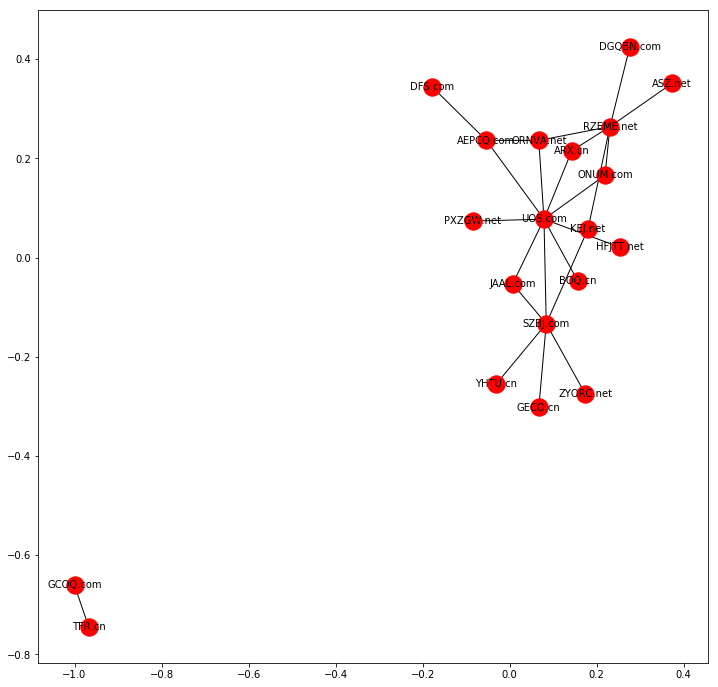

In [137]:
plt.figure(3,figsize=(12,12))
nx.draw_networkx(website_network, font_size=10)

In [138]:
sorted(nx.pagerank(website_network).items(),key=lambda x: x[1], reverse=True)

[('UOS.com', 0.17806315137246972),
 ('RZEME.net', 0.12608246055157588),
 ('SZBJ.com', 0.117830952831198),
 ('AEPCQ.com', 0.058568659723286454),
 ('ORNVA.net', 0.054539478395330764),
 ('TFR.cn', 0.05),
 ('GCOQ.com', 0.05),
 ('KEJ.net', 0.03950177030925454),
 ('JAAL.com', 0.03932734549483973),
 ('ONUM.com', 0.03794512081389001),
 ('ARX.cn', 0.03794512081389001),
 ('YHTU.cn', 0.024191997495102126),
 ('ZYORC.net', 0.024191997495102126),
 ('GECO.cn', 0.024191997495102126),
 ('DFS.com', 0.02409435758144076),
 ('DGQBN.com', 0.02280977281415241),
 ('ASZ.net', 0.02280977281415241),
 ('PXZGW.net', 0.022635347999737605),
 ('HFJTT.net', 0.022635347999737605),
 ('BOQ.cn', 0.022635347999737605)]